<a href="https://colab.research.google.com/github/AndresSebad/benchmark-vector-bbdd/blob/main/benchmark/postgres/PgVector-Test0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
%%capture
!pip install pgvector
!pip install docker
!pip install psycopg2-binary

In [19]:
try:
    import os
    import psycopg2 as pg
    from pgvector.psycopg2 import register_vector
    import numpy as np
    import pandas as pd
    import sys
    import json
    from ast import literal_eval
    from tqdm import tqdm
    import datetime
    import threading
    from matplotlib import pyplot as plt
    import datetime
    from dateutil import parser

except Exception as e:
    print(f"error: {e}")

In [107]:
class DatabaseBenchmark:
    """
    Clase para benchmark de postgres
    """
    def __init__(self, db_connection, vectorizer, trunc, table = 'embeddings', cost_per_hour = False):
        """
        db_connection: Conexión a base de datos
        vectorizer: text to vector vectorizer
        trunc: trunc svd from sparse matrix to lower dim matrix
        """

        self.db_connection = db_connection
        self.cost_per_hour = cost_per_hour
        self.vectorizer = vectorizer
        self.trunc = trunc
        self.table = table

    def query(self, query_string, n_results=1):
        query_vector = self.trunc.transform(self.vectorizer.transform([query_string]))[0].tolist()

        with self.db_connection.cursor() as cur:
            query = "SELECT * FROM {0} ORDER BY embedding <-> '{1}' LIMIT {2};".format(self.table, query_vector, n_results)
            cur.execute(query)
            results = cur.fetchall()  # Agregar esta línea
            return [record for record in results]
#
    def remove_table(self):
        cur = conn.cursor()

        # SQL command to drop the index
        drop_index_sql = "DROP TABLE IF EXISTS "+self.table+";"

        # Execute the SQL command
        cur.execute(drop_index_sql)
        conn.commit()

        # Close the connection
        #cur.close()
        #conn.close()

    def create_table(self):
        cur = self.db_connection.cursor()

        # SQL command to create an empty index
        create_index_sql = """
        CREATE TABLE """+self.table+""" (
            author TEXT,
            title TEXT,
            embedding VECTOR(64)
        );
        """

        # Execute the SQL command
        cur.execute(create_index_sql)
        conn.commit()
        #cur.close()
        #conn.close()


    def build_index(self, data, method = 'ivfflat'):
        """
        incompleta, probar con datos
        """

        self.insert_data(data)
        with self.db_connection.cursor() as cur:

            query = 'CREATE INDEX ON {0} USING {1} (embedding vector_l2_ops);'.format(self.table, method)

            results = cur.execute(query)
#
    def insert_data(self, data):
        cur = conn.cursor()

        data_list = [(row['AUTOR'], row['TITULO'], np.array(row['embedding'])) for index, row in data.iterrows()]
        cur.executemany("INSERT INTO embeddings (author, title, embedding) VALUES (%s, %s, %s)", data_list)

        conn.commit()
        #cur.close()

    def measure_qps(self, query_string, num_queries=5, n_results = 1):

        start_time = timeit.default_timer()
        for _ in range(num_queries):
            self.query(query_string= query_string, n_results= n_results)
        end_time = timeit.default_timer()

        qps = num_queries / (end_time - start_time)

        return qps

    def measure_qp_dollar(self, qps):
        if self.cost_per_hour is False:
            return "No hay costo por hora"
        qp_dollar = (qps / self.cost_per_hour) * 3600
        return qp_dollar

    def measure_latency(self, query_string, ):


        start_time = timeit.default_timer()
        self.query(query_string, 1)
        latency = timeit.default_timer() - start_time

        return latency

    def measure_index_building_time(self, data):


        start_time = timeit.default_timer()
        self.build_index(data)
        index_building_time = timeit.default_timer() - start_time

        return index_building_time

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.decomposition import TruncatedSVD
import numpy as np

def vectorize_embed(data: pd.DataFrame, datacol:str = 'TEXTO', dim = 64) -> np.array:

    vectorizer = TfidfVectorizer()
    emb = vectorizer.fit_transform(data['TEXTO'])
    svd = TruncatedSVD(dim)
    embedding = svd.fit_transform(emb)

    return vectorizer, svd, embedding

def gen_dataset(dataurl: str = 'textos.csv', datacol:str = 'TEXTO', dim = 64) ->pd.DataFrame:
    data = pd.read_csv(dataurl)
    vectorizer, svd, embedding = vectorize_embed(data, datacol, dim)
    data = data.drop(columns = datacol).reset_index(drop = True)
    data['embedding'] = [vec.tolist() for vec in embedding]
    return vectorizer, svd, data

In [22]:
def profiler(container):
    cpu_max = 0
    container_history = [] # create an empty list to store the stats
    std_array = np.zeros([50])
    std_index = 0
    for stats in container.stats(stream=True, decode=True): # iterate over the stats generator
        container_history.append(stats)
        cpu_value = stats["cpu_stats"]["cpu_usage"]["total_usage"]
        memory_value = stats["memory_stats"]["usage"]
        std_array[std_index] = cpu_value
        std_index = std_index + 1
        if std_index>=50:
            std_index = 0
        #print(std_array.std())
        if cpu_value > cpu_max:
            cpu_max = cpu_value
        if std_array.std() < 0.1*cpu_max:
            break
    return container_history

In [23]:
def cpu_usage_plot(stats_history, caption, return_percentages = False):
    cpu_total_usage = []

    wait_index = 0
    for stats in stats_history:
        if wait_index > 1:
            UsageDelta = stats['cpu_stats']['cpu_usage']['total_usage'] - stats['precpu_stats']['cpu_usage']['total_usage']
            SystemDelta = stats['cpu_stats']['system_cpu_usage'] - stats["precpu_stats"]["system_cpu_usage"]
            len_cpu = len(stats['cpu_stats']['cpu_usage']['percpu_usage'])
            percentage = (UsageDelta / SystemDelta) * len_cpu * 100
            cpu_total_usage.append(percentage)
        wait_index = wait_index + 1

    time = [stats["read"] for stats in stats_history]
    time = [parser.parse(t) for t in time]
    time_diff = [(t - time[0]).total_seconds() for t in time]
    delta = len(time_diff)-len(cpu_total_usage)
    plt.plot(time_diff[delta:], cpu_total_usage)
    plt.xlabel("Time [s]")
    plt.ylabel("CPU Percent Usage")
    plt.title("CPU usage for " + caption)
    plt.grid()
    plt.show()
    if return_percentages:
        return cpu_total_usage

In [24]:
def memory_usage_plot(stats_history, caption, return_memory = False):
    memory_total_usage = []

    wait_index = 0
    for stats in stats_history:
        if wait_index > 1:
            memory = stats["memory_stats"]["usage"]/(1024**2)
            memory_total_usage.append(memory)
        wait_index = wait_index + 1

    time = [stats["read"] for stats in stats_history]
    time = [parser.parse(t) for t in time]
    time_diff = [(t - time[0]).total_seconds() for t in time]
    delta = len(time_diff)-len(memory_total_usage)
    plt.plot(time_diff[delta:], memory_total_usage)
    plt.xlabel("Time [s]")
    plt.ylabel("Memory Usage (MB)")
    plt.title("Memory usage for " + caption)
    plt.grid()
    plt.show()
    if return_memory:
        return memory_total_usage

In [25]:
def io_usage_plot(stats_history, caption, return_io = False):
    io_rx_total_usage = []
    io_tx_total_usage = []

    wait_index = 0
    for stats in stats_history:
        if wait_index > 1:
            rx = stats["networks"]["eth0"]["rx_bytes"]/(1024**2)
            tx = stats["networks"]["eth0"]["tx_bytes"]/(1024**2)
            io_rx_total_usage.append(rx)
            io_tx_total_usage.append(tx)
        wait_index = wait_index + 1

    time = [stats["read"] for stats in stats_history]
    time = [parser.parse(t) for t in time]
    time_diff = [(t - time[0]).total_seconds() for t in time]
    delta = len(time_diff)-len(io_tx_total_usage)
    plt.plot(time_diff[delta:], io_rx_total_usage, label="RX")
    plt.plot(time_diff[delta:], io_tx_total_usage, label = "TX")
    plt.legend(loc="upper left")
    plt.xlabel("Time [s]")
    plt.ylabel("Network Usage")
    plt.title("Network for " + caption)
    plt.grid()
    plt.legend()
    plt.show()
    if return_io:
        return io_total_usage

In [26]:
vectorizer, svd, data = gen_dataset("textos.csv")

In [27]:
import docker
import timeit
import statistics
client = docker.from_env()

pgvector_container = client.containers.get("36c118bf7d8075c9772f76615ab04cc91018f0e33d8d0cc6dffe0fdd4c5162a6")
start_time = timeit.default_timer()
pgvector_container.start()
pgvector_stats_history = profiler(pgvector_container)
pgvector_container_docker_start_time = timeit.default_timer() - start_time
print(f"It took {pgvector_container_docker_start_time} to run pgvector")


It took 50.542823 to run pgvector


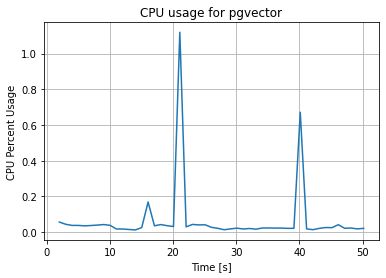

In [28]:
cpu_usage_plot(pgvector_stats_history, "pgvector", False)

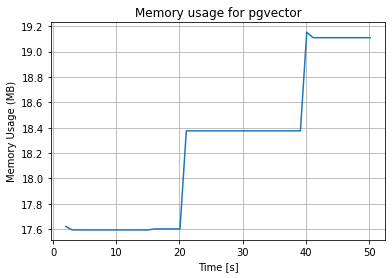

In [29]:
memory_usage_plot(pgvector_stats_history, "pgvector")

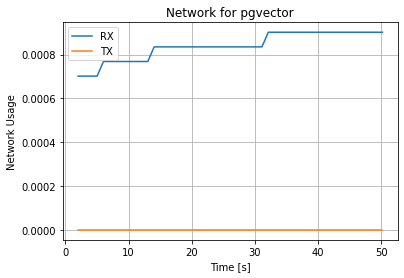

In [30]:
io_usage_plot(pgvector_stats_history, "pgvector")

In [108]:
conn.close()

In [109]:
conn = pg.connect(dbname='vectordb', user='testuser', password='testpwd', host='localhost', port='5432')
register_vector(conn)
pgvector_stats_history = profiler(pgvector_container)

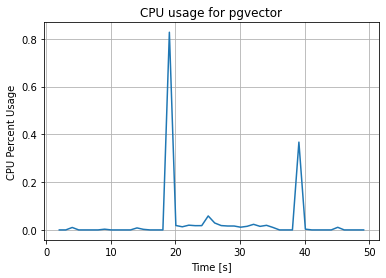

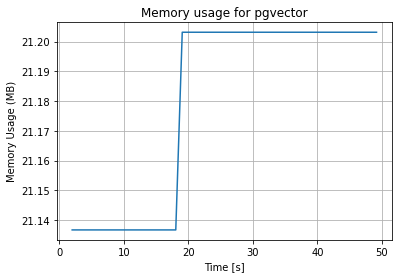

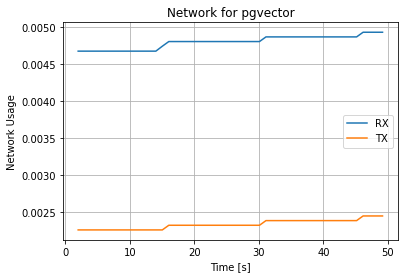

In [35]:
cpu_usage_plot(pgvector_stats_history, "pgvector", False)
memory_usage_plot(pgvector_stats_history, "pgvector")
io_usage_plot(pgvector_stats_history, "pgvector")

In [110]:
Benchmark = DatabaseBenchmark(conn, vectorizer, svd)
Benchmark.remove_table()
Benchmark.create_table()
pgvector_stats_history = profiler(pgvector_container)
cpu_usage_plot(pgvector_stats_history, "pgvector", False)
memory_usage_plot(pgvector_stats_history, "pgvector")
io_usage_plot(pgvector_stats_history, "pgvector")

In [111]:
ibt = Benchmark.measure_index_building_time(data)
pgvector_stats_history = profiler(pgvector_container)
cpu_usage_plot(pgvector_stats_history, "pgvector", False)
memory_usage_plot(pgvector_stats_history, "pgvector")
io_usage_plot(pgvector_stats_history, "pgvector")

In [112]:
qps = Benchmark.measure_qps(query_string="Don Quijote", num_queries = 1000)
es01_stats_history = profiler(es01_container)
cpu_usage_plot(es01_stats_history, "ES01", False)
memory_usage_plot(es01_stats_history, "ES01")
io_usage_plot(es01_stats_history, "ES01")

In [113]:
print("QPs", qps)

QPs 28.563803994422653


# Threads approach:

In [114]:
import docker
import time
from threading import Thread, Event
from queue import Queue
time_constant = 30

# A function that gets the docker stats and puts them in a queue
def get_docker_stats(queue_in, queue_out, event):
    print("Starting profile")
    client = docker.from_env()
    container = client.containers.get("36c118bf7d8075c9772f76615ab04cc91018f0e33d8d0cc6dffe0fdd4c5162a6") # Change this to your container name or id
    temp_stats = []
    #while not event.is_set():
    cpu_max = 0
    container_history = [] # create an empty list to store the stats
    std_array = np.zeros([50])
    std_index = 0
    for stats in container.stats(stream=True, decode=True): # iterate over the stats generator
        container_history.append(stats)
        cpu_value = stats["cpu_stats"]["cpu_usage"]["total_usage"]
        std_array[std_index] = cpu_value
        std_index = std_index + 1
        if std_index>=50:
            std_index = 0
        #print(std_array.std())
        if cpu_value > cpu_max:
            cpu_max = cpu_value
        if std_array.std() < 0.1*cpu_max:
            break
    #return container_history
    print("Profile ended")
    queue_out.put(container_history)

        #mem_usage = stats["memory_stats"]["usage"]
        #mem_usage_mb = mem_usage / (1024**2)
        #cpu_usage = stats["cpu_stats"]["cpu_usage"]["total_usage"]
        #temp_stats.append(stats)
        #time.sleep(0.1) # Change this to your desired interval



def containers_initializer(queue_in, queue_out, event):
    #while not event.is_set():
    client = docker.from_env()

    pgvector_container = client.containers.get("36c118bf7d8075c9772f76615ab04cc91018f0e33d8d0cc6dffe0fdd4c5162a6")
    print("Starting pgvector")
    pgvector_container.start()
    result = "Done"
    queue_out.put(result)
    time.sleep(time_constant)


def pgvector_initializer(queue_in, queue_out, event):
    #while not event.is_set():

    print("Initializing pgvector")
    conn = pg.connect(dbname='vectordb', user='testuser', password='testpwd', host='localhost', port='5432')
    register_vector(conn)
    result = "Done"
    queue_out.put(result)
    time.sleep(time_constant)

def pgvector_reset_table(queue_in, queue_out, event):
    #while not event.is_set():
    print("Resetting index")
    Benchmark = DatabaseBenchmark(conn, vectorizer, svd)
    Benchmark.remove_table()
    Benchmark.create_table()
    result = "Done"
    print(result)
    queue_out.put(result)
    time.sleep(time_constant)

def pgvector_build_index(queue_in, queue_out, event):
    #while not event.is_set():
    print("Building index")
    ibt = Benchmark.measure_index_building_time(data)
    queue_out.put(ibt)
    print("Done")
    time.sleep(time_constant)

def pgvector_measure_qps(queue_in, queue_out, event):
    #while not event.is_set():
    print("Measuring QPS")
    qps = Benchmark.measure_qps(query_string="Don Quijote", num_queries = 1000)
    queue_out.put(qps)
    print("Done")
    time.sleep(time_constant)


Containers initialization:

In [115]:
# Create two queues, one for each thread
queue1 = Queue()
queue2 = Queue()

# Create an event object to signal the threads to stop
event = Event()

# Create two threads, each with a target function and the queues as arguments
t1 = Thread(target=get_docker_stats, args=(queue1, queue2, event))
t2 = Thread(target=containers_initializer, args=(queue2, queue1, event))

# Start the threads
t1.start()
t2.start()

forced_wait = 100
t0 = time.time()
while time.time() - t0 < forced_wait:
    try:
        time.sleep(1)
    except KeyboardInterrupt:
        event.set()
        break
event.set()


# Join the threads
t1.join()
t2.join()

# Print the contents of the queues
if not queue1.empty():
    function_results = queue1.get()
if not queue2.empty():
    containers_initializer_thread_stats = queue2.get()

Starting profile
Starting pgvector
Profile ended


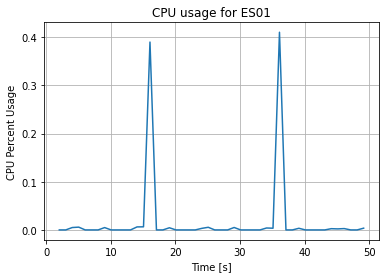

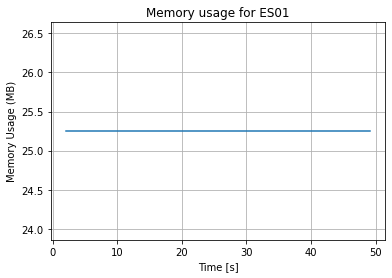

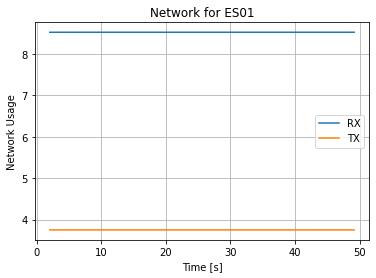

In [116]:
cpu_usage_plot(containers_initializer_thread_stats, caption="pgvector")
memory_usage_plot(containers_initializer_thread_stats, caption="pgvector")
io_usage_plot(containers_initializer_thread_stats, caption="pgvector")

pgvector initialization

In [118]:
# Create two queues, one for each thread
queue1 = Queue()
queue2 = Queue()

# Create an event object to signal the threads to stop
event = Event()

# Create two threads, each with a target function and the queues as arguments
t1 = Thread(target=get_docker_stats, args=(queue1, queue2, event))
t2 = Thread(target=pgvector_initializer, args=(queue2, queue1, event))

# Start the threads
t1.start()
t2.start()

forced_wait = 100
t0 = time.time()
while time.time() - t0 < forced_wait:
    try:
        time.sleep(1)
    except KeyboardInterrupt:
        event.set()
        break
event.set()

# Join the threads
t1.join()
t2.join()

# Print the contents of the queues
if not queue1.empty():
    pgvector_initializer_function_results = queue1.get()
if not queue2.empty():
    pgvector_initializer_thread_stats = queue2.get()

Starting profile
Initializing pgvector
Profile ended


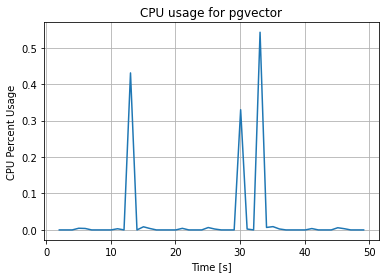

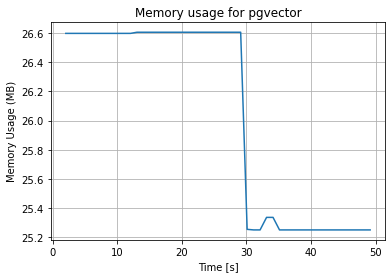

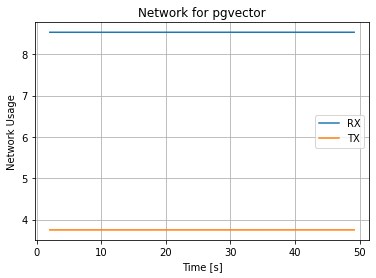

In [119]:
cpu_usage_plot(pgvector_initializer_thread_stats, caption="pgvector")
memory_usage_plot(pgvector_initializer_thread_stats, caption="pgvector")
io_usage_plot(pgvector_initializer_thread_stats, caption="pgvector")

pgvector reset index and tables

In [122]:
# Create two queues, one for each thread
queue1 = Queue()
queue2 = Queue()

# Create an event object to signal the threads to stop
event = Event()

# Create two threads, each with a target function and the queues as arguments
t1 = Thread(target=get_docker_stats, args=(queue1, queue2, event))
t2 = Thread(target=pgvector_reset_table, args=(queue2, queue1, event))

# Start the threads
t1.start()
t2.start()

forced_wait = 100
t0 = time.time()
while time.time() - t0 < forced_wait:
    try:
        time.sleep(1)
    except KeyboardInterrupt:
        event.set()
        break
event.set()

# Join the threads
t1.join()
t2.join()

# Print the contents of the queues
if not queue1.empty():
    pgvector_reset_index_function_results = queue1.get()
if not queue2.empty():
    pgvector_reset_index_thread_stats = queue2.get()

Starting profile
Resetting index
Done
Profile ended


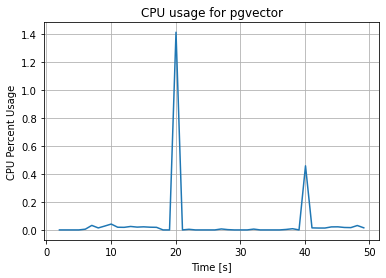

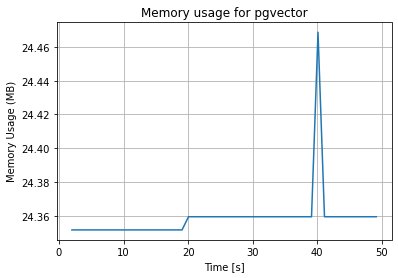

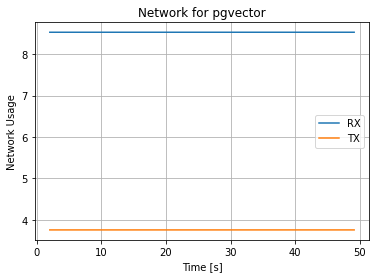

In [123]:
cpu_usage_plot(pgvector_reset_index_thread_stats, caption="pgvector")
memory_usage_plot(pgvector_reset_index_thread_stats, caption="pgvector")
io_usage_plot(pgvector_reset_index_thread_stats, caption="pgvector")

pgvector build index

In [124]:
# Create two queues, one for each thread
queue1 = Queue()
queue2 = Queue()

# Create an event object to signal the threads to stop
event = Event()

# Create two threads, each with a target function and the queues as arguments
t1 = Thread(target=get_docker_stats, args=(queue1, queue2, event))
t2 = Thread(target=pgvector_build_index, args=(queue2, queue1, event))

# Start the threads
t1.start()
t2.start()

forced_wait = 100
t0 = time.time()
while time.time() - t0 < forced_wait:
    try:
        time.sleep(1)
    except KeyboardInterrupt:
        event.set()
        break
event.set()

# Join the threads
t1.join()
t2.join()

# Print the contents of the queues
if not queue1.empty():
    pgvector_build_index_function_results = queue1.get()
if not queue2.empty():
    pgvector_build_index_thread_stats = queue2.get()

Starting profile
Building index
Done
Profile ended


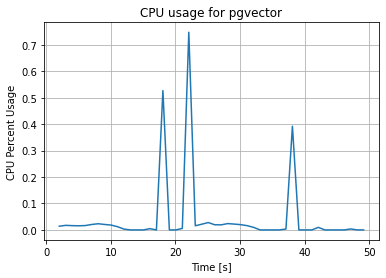

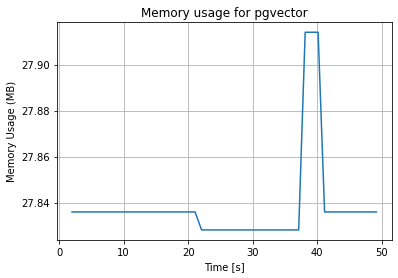

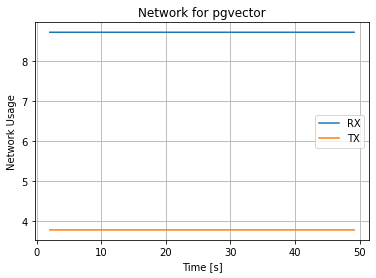

In [125]:
cpu_usage_plot(pgvector_build_index_thread_stats, caption="pgvector")
memory_usage_plot(pgvector_build_index_thread_stats, caption="pgvector")
io_usage_plot(pgvector_build_index_thread_stats, caption="pgvector")

Elastic measure QPS

In [126]:
# Create two queues, one for each thread
queue1 = Queue()
queue2 = Queue()

# Create an event object to signal the threads to stop
event = Event()

# Create two threads, each with a target function and the queues as arguments
t1 = Thread(target=get_docker_stats, args=(queue1, queue2, event))
t2 = Thread(target=pgvector_measure_qps, args=(queue2, queue1, event))

# Start the threads
t1.start()
t2.start()

forced_wait = 100
t0 = time.time()
while time.time() - t0 < forced_wait:
    try:
        time.sleep(1)
    except KeyboardInterrupt:
        event.set()
        break
event.set()

# Join the threads
t1.join()
t2.join()

# Print the contents of the queues
if not queue1.empty():
    pgvector_measure_qps_function_results = queue1.get()
if not queue2.empty():
    pgvector_measure_qps_thread_stats = queue2.get()

Starting profile
Measuring QPS
Done
Profile ended


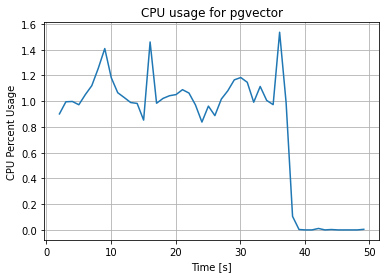

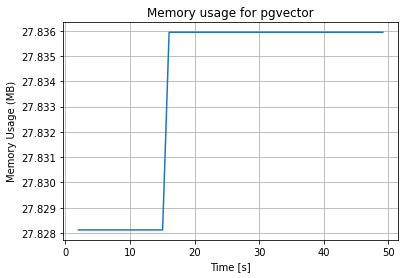

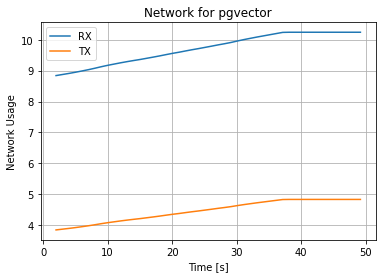

In [127]:
cpu_usage_plot(pgvector_measure_qps_thread_stats, caption="pgvector")
memory_usage_plot(pgvector_measure_qps_thread_stats, caption="pgvector")
io_usage_plot(pgvector_measure_qps_thread_stats, caption="pgvector")

Rastros de una anterior versión:

In [ ]:
#print(f'Index Building Time: {ibt} Segundos \nQueries Per Second: {qps}\nQuery Latency: {ql} Segundos')

NameError: name 'ql' is not defined

In [ ]:
#query = es.search(
#            index="news_index",
#            body={
#            "size": 1,
#            "query": {
#                "match":{
#                    "AUTOR": "¿Quién es Quijote de la Mancha?"
#                }
#            }
#            }
#        )
#output = pd.json_normalize((query['hits']['hits']))

In [ ]:
#dataset = pd.read_csv("/textos.csv")
#print(f"shape of dataset: {dataset.shape}")
#dataset.head()

In [ ]:
#MY_INDEX = es.indices.create(index="news_index", ignore=[400,404], body=Settings)
#MY_INDEX

In [ ]:
#json_Formatted_dataset = json_formatter(dataset=dataset, index_name='news_index', index_type='_doc')
#json_Formatted_dataset[0]

In [ ]:
# For importing Data to elasticsearch we use elasticsearch's bulk API from elasticsearch.helpers
#try:
#    res = helpers.bulk(es, json_Formatted_dataset)
#    print("successfully imported to elasticsearch.")
#except Exception as e:
#    print(f"error: {e}")

# Vector search for Elastic



Otros enlaces importantes:
https://colab.research.google.com/github/HamidRezaAttar/Elasticsearch-Jupyter-Colab/blob/main/notebooks/python-elasticsearch-colab.ipynb#scrollTo=KgU86UyYNHLq

https://colab.research.google.com/github/tensorflow/io/blob/master/docs/tutorials/elasticsearch.ipynb#scrollTo=XkXyocIdKRSB